In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import os
from tensorflow import convert_to_tensor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN


In [122]:
def generate_time_series( n_steps):
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin(time)
    series += 0.1 * (np.random.rand(n_steps) - 0.5)
    return series[...,np.newaxis].astype(np.float32)

In [123]:
generate_time_series(20)

array([[0.00259916],
       [0.00120816],
       [0.08194153],
       [0.09056449],
       [0.09988842],
       [0.10625289],
       [0.14287157],
       [0.17599274],
       [0.23370138],
       [0.20403887],
       [0.24072272],
       [0.29968634],
       [0.27473572],
       [0.27939522],
       [0.3595843 ],
       [0.3537783 ],
       [0.3994712 ],
       [0.41879663],
       [0.45228684],
       [0.45340458]], dtype=float32)

In [63]:
def forecast(model, start, y_all, sequence_length):
    N = len(y_all)-start
    A = y_all[start-sequence_length:start].to_numpy().reshape(-1,1).T
    y_pred = list()
    for i in range(N):
        z = A
        z = convert_to_tensor(z)
        r = model(z)
        y_pred.append(r[0,0])
        A = np.append(A[0,1:], r[0,0]).reshape(-1,1).T
    y_pred = pd.Series(y_pred,index=y_all.index[start:])
    return y_pred

# Load the data

In [3]:
def MAE(x):
    return np.abs(x).mean() 

def RMSE(x):
    return np.sqrt( np.square(x).mean() )

def plot_decomp(y_hist,y_future,D):
    plt.figure(figsize=(14,4))
    plt.plot(D['residue'],'k')
    plt.plot(D['pred_error'],'m')

    plt.figure(figsize=(16,5))
    plt.plot(y_hist,'k',label='data',linewidth=1)
    plt.plot(D['season_and_trend'],label='model',color='royalblue',linewidth=3)
    plt.plot(D['yhat'],label='forecast',color='limegreen',linewidth=3)
    plt.plot(y_future,'k',alpha=0.5,linewidth=1)

In [4]:
with open('decomp.pkl', 'rb') as file:
    X = pickle.load(file)

history = X['history']
y_hist = history['y_hist']
future = X['future']
y_future = future['y_future']
y_all = y_hist.append(y_future)

Nhist = len(y_hist)

time_all = y_all.index
time_hist = y_hist.index
time_future = y_future.index


decomp = {}
decomp['season_and_trend'] = history['t_and_s']
decomp['residue'] = y_hist - history['t_and_s']
decomp['MAEm'] = MAE(decomp['residue'])
decomp['RMSEm'] = RMSE(decomp['residue'])
decomp['y_future'] = future['y_future']
decomp['yhat'] = future['y_hat']
decomp['pred_error'] = decomp['y_future'] - decomp['yhat']
decomp['MAEp'] = MAE(decomp['pred_error'])
decomp['RMSEp'] = RMSE(decomp['pred_error'])

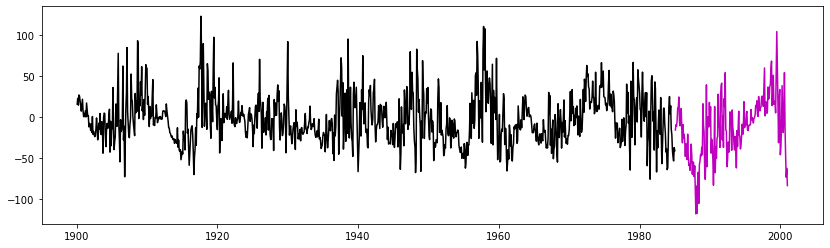

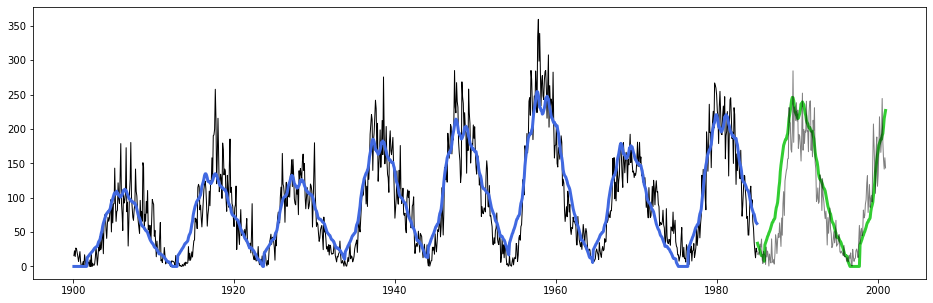

In [5]:
plot_decomp(y_hist,y_future,decomp)

# Train test data

In [76]:
sequence_length = 50
lookahead = 1
delay = sequence_length + lookahead - 1

train_data = y_hist
train_target = np.zeros(y_hist.shape)
train_target[:-delay] = y_hist[delay:]
train_target = pd.Series(train_target,index = train_data.index)

train_dataset = timeseries_dataset_from_array(
    data = train_data,
    targets= train_target,
    sequence_length = sequence_length,
    batch_size = 1 )

test_data = y_all[Nhist-delay:]
test_target = np.zeros(test_data.shape)
test_target[:-delay] = y_all[Nhist:]
test_target = pd.Series(test_target,index = test_data.index)

test_dataset = timeseries_dataset_from_array(
    data = test_data,
    targets= test_target,
    sequence_length = sequence_length,
    batch_size = 1 )

# Dense neural network

In [77]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(5, activation="relu")(x)
outputs = layers.Dense(1)(x)
model_dense = keras.Model(inputs, outputs)
model_dense.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model_dense.fit(train_dataset,epochs=10)

Epoch 1/10
971/971 [==============================] - 1s 444us/step - loss: 2092.5407 - mae: 34.5947
Epoch 2/10
971/971 [==============================] - 0s 443us/step - loss: 1496.5082 - mae: 28.5541
Epoch 3/10
971/971 [==============================] - 0s 444us/step - loss: 1317.4287 - mae: 26.5071
Epoch 4/10
971/971 [==============================] - 0s 436us/step - loss: 1179.7464 - mae: 24.7959
Epoch 5/10
971/971 [==============================] - 0s 435us/step - loss: 1089.1382 - mae: 23.5969
Epoch 6/10
971/971 [==============================] - 0s 433us/step - loss: 1025.0565 - mae: 22.7391
Epoch 7/10
971/971 [==============================] - 0s 432us/step - loss: 990.0702 - mae: 22.2264
Epoch 8/10
971/971 [==============================] - 0s 438us/step - loss: 965.3281 - mae: 21.8502
Epoch 9/10
971/971 [==============================] - 0s 442us/step - loss: 944.1094 - mae: 21.5303
Epoch 10/10
971/971 [==============================] - 0s 440us/step - loss: 898.2528 - mae: 2

In [78]:
y_hist_hat = model_dense.predict(train_dataset)
y_future_hat = model_dense.predict(test_dataset)
t_hist_hat = time_hist[delay-1:(delay+len(y_hist_hat))]
t_future_hat = time_all[-len(y_future_hat):]

# training and testing error

In [79]:
model_dense.evaluate(train_dataset)

971/971 [==============================] - 0s 374us/step - loss: 1368.0813 - mae: 27.1571


[1368.081298828125, 27.157066345214844]

In [80]:
model_dense.evaluate(test_dataset)

193/193 [==============================] - 0s 415us/step - loss: 1511.3816 - mae: 27.7811


[1511.381591796875, 27.781057357788086]

(100, 12000)

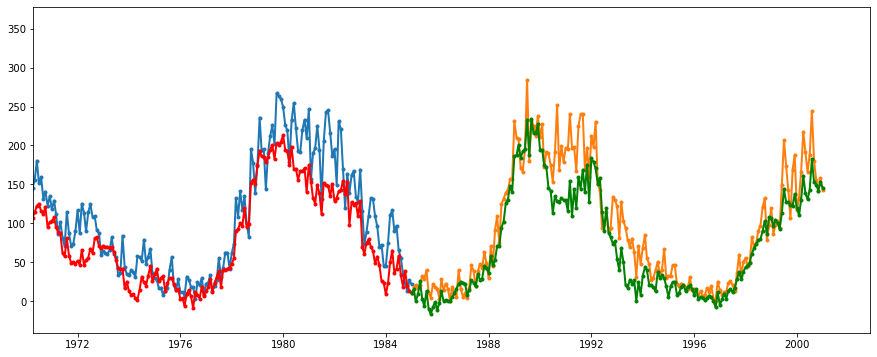

In [81]:
plt.figure(figsize=(15,6))
plt.plot(y_hist,marker='.',linewidth=2)
plt.plot(y_future,marker='.',linewidth=2)
plt.plot(t_hist_hat,y_hist_hat,linewidth=2,marker='.',color='r')
plt.plot(t_future_hat,y_future_hat,linewidth=2,marker='.',color='g')
plt.xlim(100,12000)

# Forecast

In [82]:
start = 1020
y_pred = forecast(model_dense, start, y_all, sequence_length)

(100, 12000)

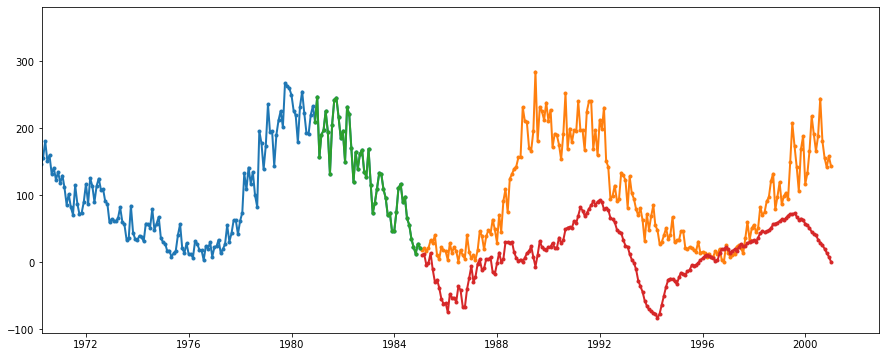

In [83]:
plt.figure(figsize=(15,6))
plt.plot(y_hist,marker='.',linewidth=2)
plt.plot(y_future,marker='.',linewidth=2)
plt.plot(y_all[start-sequence_length:start],marker='.',linewidth=2)
plt.plot(y_pred,marker='.',linewidth=2)
plt.xlim(100,12000)

# RNN

In [111]:
model_rnn = keras.models.Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(1)
])

model_rnn.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model_rnn.fit(train_dataset,epochs=10)

Epoch 1/10


ValueError: in user code:

    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/gomes/miniconda3/envs/d178/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)


In [103]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.SimpleRNN(3, return_sequences=True)(inputs)
outputs = layers.Dense(1)(x)
model_rnn = keras.Model(inputs, outputs)
model_rnn.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model_rnn.fit(train_dataset,epochs=10)

Epoch 1/10
971/971 [==============================] - 3s 3ms/step - loss: 9723.7550 - mae: 78.0760
Epoch 2/10
971/971 [==============================] - 3s 3ms/step - loss: 9158.7855 - mae: 74.6185
Epoch 3/10
971/971 [==============================] - 3s 3ms/step - loss: 8694.0248 - mae: 71.9945
Epoch 4/10
971/971 [==============================] - 3s 3ms/step - loss: 8267.3166 - mae: 69.7188
Epoch 5/10
971/971 [==============================] - 3s 3ms/step - loss: 7876.2013 - mae: 67.6626
Epoch 6/10
971/971 [==============================] - 3s 3ms/step - loss: 7518.8568 - mae: 65.8292
Epoch 7/10
971/971 [==============================] - 3s 3ms/step - loss: 7193.1750 - mae: 64.1797
Epoch 8/10
971/971 [==============================] - 3s 3ms/step - loss: 6896.8384 - mae: 62.7132
Epoch 9/10
971/971 [==============================] - 3s 3ms/step - loss: 6627.4038 - mae: 61.3668
Epoch 10/10
971/971 [==============================] - 3s 3ms/step - loss: 6382.4266 - mae: 60.1195


In [88]:
# y_future_hat = model_rnn.predict(test_dataset)


In [104]:
for seq, trgt in test_dataset:
    print(seq)
    print(model_rnn.predict(seq))
    break

tf.Tensor(
[[209.5 246.9 156.6 189.9 196.6 225.3 194.7 131.6 205.3 242.5 245.3 216.2
  186.  195.4 149.8 230.9 221.1 170.3 119.3 163.7 139.4 161.9 167.4 134.3
  127.5 169.  115.5  73.1  88.7 109.6 132.5 131.5 108.9  96.   69.9  72.5
   45.7  45.6  74.8 110.2 116.7  90.4  96.9  65.1  55.7  35.   22.6  12.6
   26.5  21.4]], shape=(1, 50), dtype=float64)
[[[29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.02198]
  [29.021

In [86]:
y_pred = forecast(model_rnn, start, y_all, sequence_length)

ValueError: x and y can be no greater than 2D, but have shapes (193,) and (193, 50, 1)

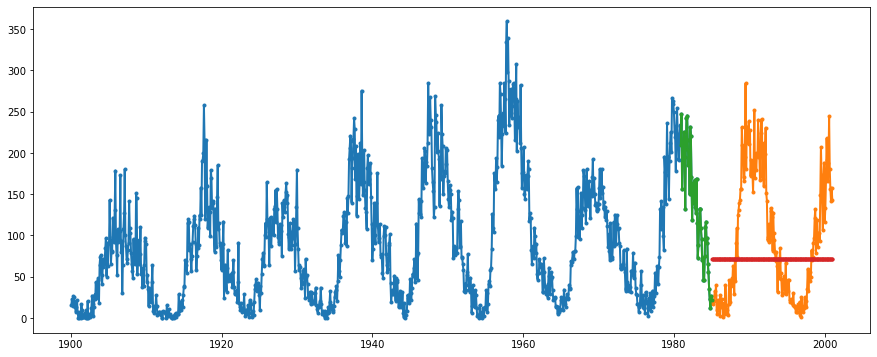

In [89]:
plt.figure(figsize=(15,6))
plt.plot(y_hist,marker='.',linewidth=2)
plt.plot(y_future,marker='.',linewidth=2)
plt.plot(y_all[start-sequence_length:start],marker='.',linewidth=2)
plt.plot(y_pred,marker='.',linewidth=2)
plt.plot(t_future_hat,y_future_hat,linewidth=2,marker='.',color='g')

plt.xlim(100,12000)

In [37]:
model_rnn.layers


# LSTM

In [44]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(20)(inputs)
outputs = layers.Dense(1)(x)
model_lstm = keras.Model(inputs, outputs)
model_lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model_lstm.fit(train_dataset,epochs=10)

Epoch 1/10
921/921 [==============================] - 12s 12ms/step - loss: 9044.1246 - mae: 71.2002
Epoch 2/10
921/921 [==============================] - 10s 11ms/step - loss: 7388.0721 - mae: 62.0274
Epoch 3/10
921/921 [==============================] - 11s 12ms/step - loss: 6237.5767 - mae: 56.2071
Epoch 4/10
921/921 [==============================] - 11s 11ms/step - loss: 5250.5303 - mae: 49.5095
Epoch 5/10
921/921 [==============================] - 11s 12ms/step - loss: 4449.8617 - mae: 44.1431
Epoch 6/10
921/921 [==============================] - 11s 12ms/step - loss: 3799.2634 - mae: 39.7214
Epoch 7/10
921/921 [==============================] - 11s 12ms/step - loss: 3269.3345 - mae: 36.1146
Epoch 8/10
921/921 [==============================] - 12s 13ms/step - loss: 2838.4344 - mae: 33.2432
Epoch 9/10
921/921 [==============================] - 12s 13ms/step - loss: 2494.1258 - mae: 30.9640
Epoch 10/10
921/921 [==============================] - 12s 13ms/step - loss: 2213.9765 - ma

In [45]:
y_pred = forecast(model_lstm, start, y_all, sequence_length)

(100, 12000)

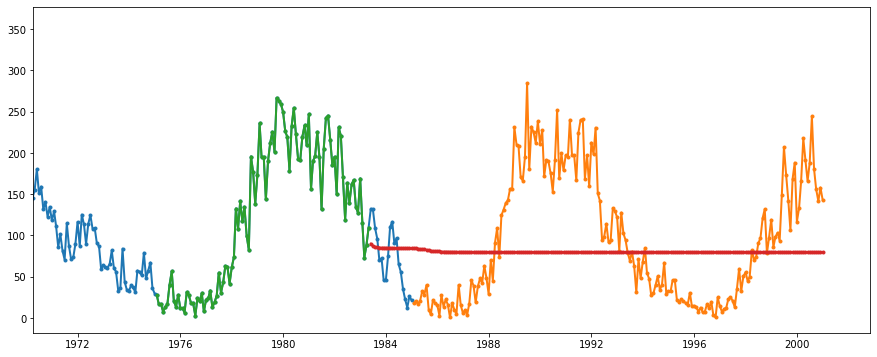

In [46]:
plt.figure(figsize=(15,6))
plt.plot(y_hist,marker='.',linewidth=2)
plt.plot(y_future,marker='.',linewidth=2)
plt.plot(y_all[start-sequence_length:start],marker='.',linewidth=2)
plt.plot(y_pred,marker='.',linewidth=2)
plt.xlim(100,12000)